In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

%matplotlib inline 

In [12]:
# reading the data
color_df = pd.read_csv("Data/final_data_colors.csv")
color_df.head(5)

,red,green,blue,label
0,20,139,240,Blue
1,174,83,72,Brown
2,144,249,131,Green
3,168,25,156,Pink
4,30,182,136,Green


### First insights

In [17]:
df_dim = color_df.shape
color_df.info()
print(f"the data set is of dimension {df_dim}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   red     5052 non-null   int64 
 1   green   5052 non-null   int64 
 2   blue    5052 non-null   int64 
 3   label   5052 non-null   object
dtypes: int64(3), object(1)
memory usage: 158.0+ KB
the data set is of dimension (5052, 4)


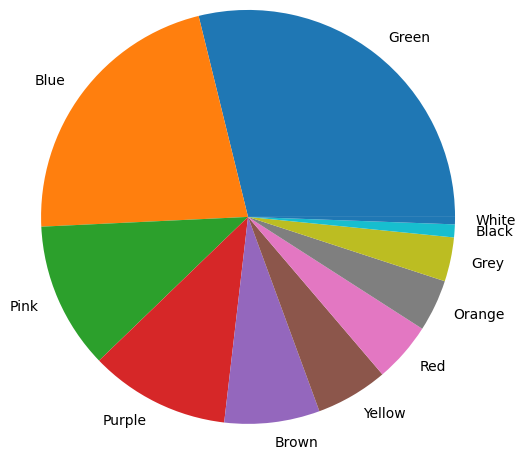

In [47]:
c_labels = color_df.label.value_counts().index.tolist()
c_count = color_df.label.value_counts().values.tolist()
plt.pie(x = c_count, labels = c_labels, radius=1.4);

There are 5052 row in the data set

There aren't any null values in the data set

The colors labers aren't equaly destirbuted

### Data processing and handling

In [67]:
X_df = color_df.iloc[:, :3]
Y_df = color_df.iloc[:, 3]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, stratify=Y_df)

In [94]:
# we will use over sampling technique exactly SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

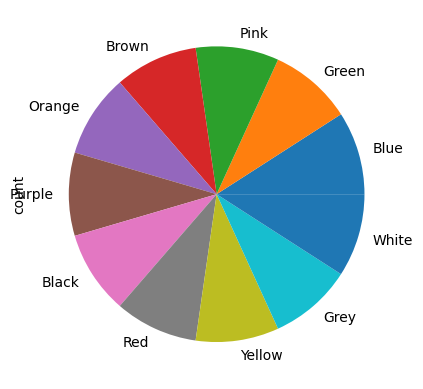

In [95]:
y_train_res.value_counts().plot(kind = "pie");

#### note: No need for Standard Scaler since all of the features are in the range of 0-255

### Building the models

#### K-NN

In [136]:
accuracy_list = []
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res, y_train_res)
    y_hat = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)
    accuracy_list.append(accuracy)


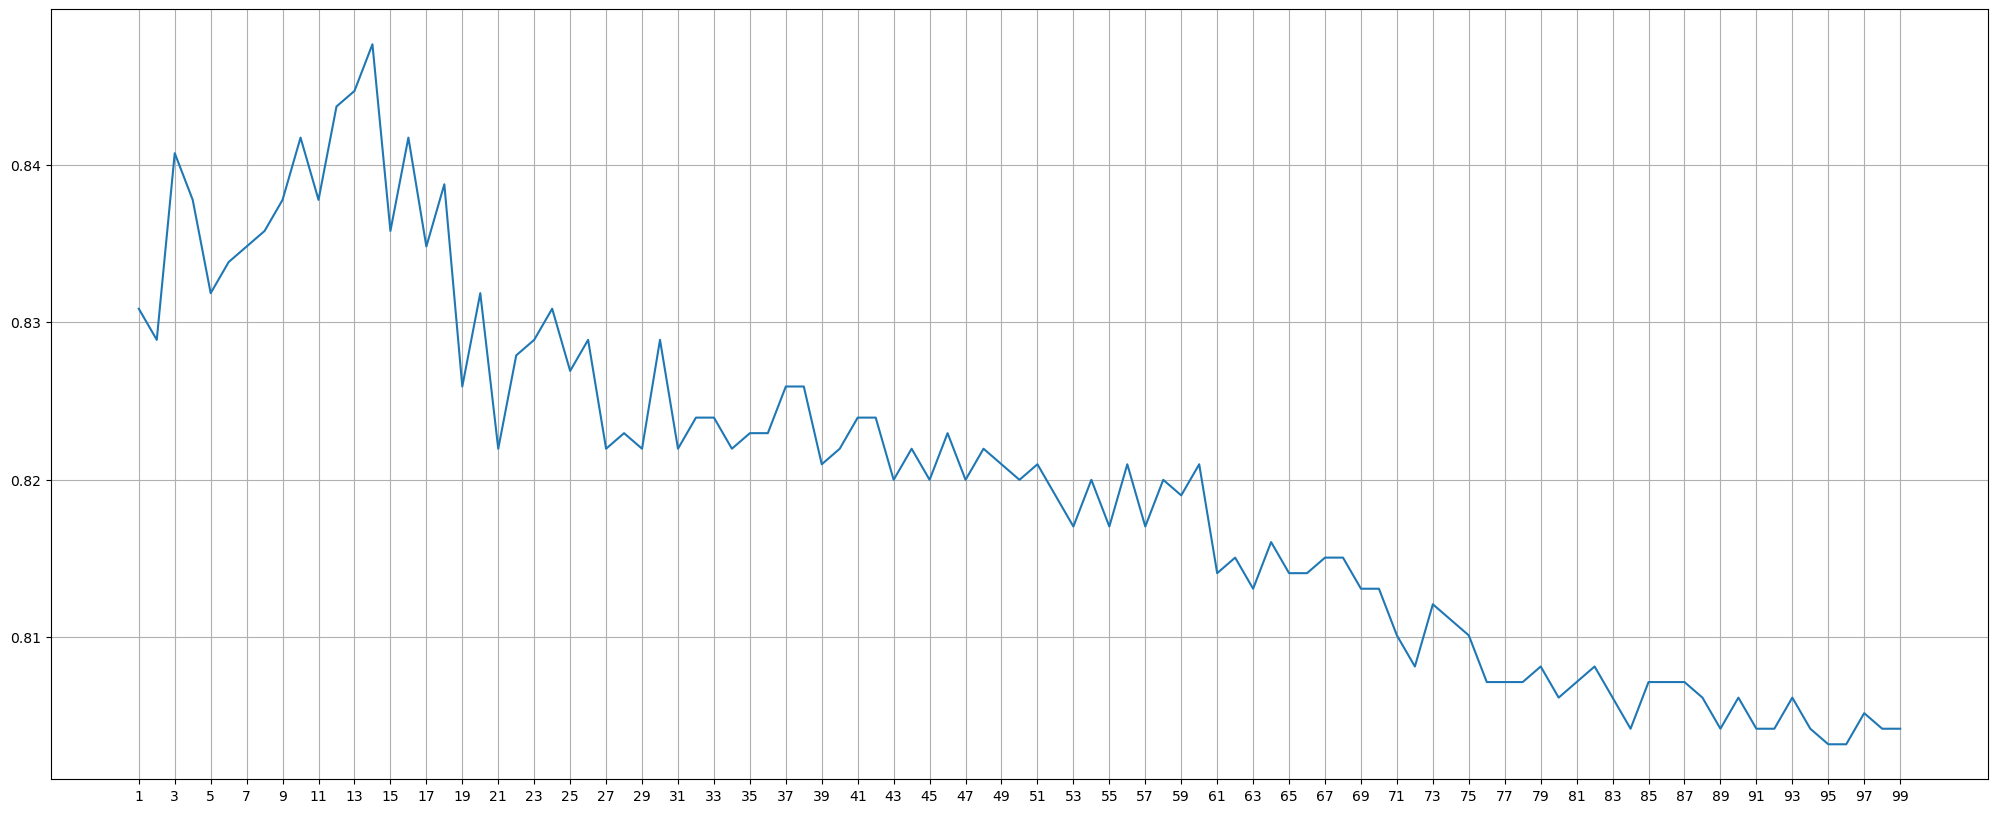

In [137]:
plt.figure(figsize=(25, 10))
plt.plot(range(1, 100), accuracy_list);
plt.xticks(range(1, 100, 2));
plt.grid(True)

the optimal value for the n_neighbors is 14

#### Logistic Regression

In [144]:
lr = LogisticRegression(random_state=42, solver='liblinear') # multi_class parameter since we have 11 classes
lr.fit(X_train_res, y_train_res)
y_hat = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)

print(accuracy)

0.7705242334322453


In [ ]:
y_test

#### XGBoost 

In [199]:
# use Label Encoder as itis a requirment since version 1.3.2
le = LabelEncoder()
bst_y_train = le.fit_transform(y_train_res)
bst_y_test = le.fit_transform(y_test)
# the model
bst  = XGBClassifier(n_estimators=20, max_depth=5, learning_rate=1, objective='binary:logistic')
bst .fit(X_train_res, bst_y_train)
y_hat = bst .predict(X_test)
accuracy = accuracy_score(bst_y_test, y_hat)

print(accuracy)

0.8526211671612265


#### Support Vector Classification.

In [204]:
svm  = SVC(random_state=42, probability=True) 
svm.fit(X_train_res, y_train_res)
y_hat = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)

print(accuracy)

0.7705242334322453


#### Decision Tree

In [234]:
dtc  = DecisionTreeClassifier(random_state=42, criterion = "entropy", max_depth=20,min_samples_split = 2) 
dtc.fit(X_train_res, y_train_res)
y_hat = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)

print(accuracy)

0.8318496538081108


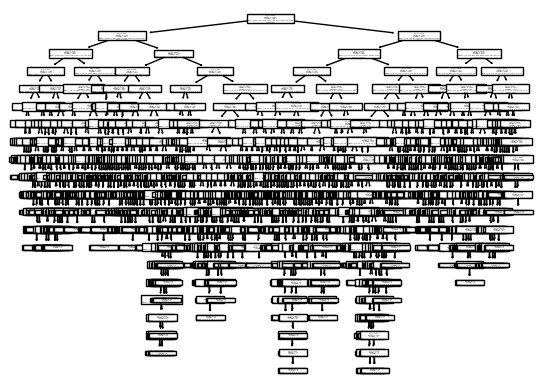

In [236]:
from sklearn import tree
tree.plot_tree(dtc);

not the smartest idea 😅

#### Random Forest

In [237]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20)
rf.fit(X_train_res, y_train_res)
y_hat = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)

print(accuracy)

0.8724035608308606


### stacking classifier

In [259]:
base_classifiers = [
    ('RF', RandomForestClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(random_state=42, probability=True)),
]
final_estimators = DecisionTreeClassifier(random_state=42)

In [262]:
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=final_estimators,
    cv=5
)

In [263]:
stacking_classifier.fit(X_train_res, y_train_res)
stacking_Y_hat = stacking_classifier.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_Y_hat)
print("\nStacking Classifier Accuracy:", stacking_accuracy)


Stacking Classifier Accuracy: 0.8199802176063303


### fine tuning and getting the hiest model 

In [269]:
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Stacking Classifier': stacking_classifier
}

In [273]:
results = {}
for name, model in models.items():
    if name != "XGBoost": # better approach is to encode the responce variable from the begining 
        model.fit(X_train_res, y_train_res) 
        y_hat = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_hat)
    else:
        model.fit(X_train_res, bst_y_train)
        y_hat = model.predict(X_test)
        accuracy = accuracy_score(bst_y_test, y_hat)
    results[name] = accuracy

KNN
SVM
Logistic Regression


C:\Users\engpe\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Random Forest
Decision Tree
Stacking Classifier


In [282]:
# geting the maximum accuracy
best_model_name, best_accuracy = max(results, key=results.get), results[best_model_name]
print(f"the model with the highest accuracy is {best_model_name} with a value of {best_accuracy}")

the model with the highest accuracy is Random Forest with a value of 0.8684470820969338


#### tuning Random Forest model

In [297]:
rf = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100,200, 500],
    'max_depth' : [4, 5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [298]:
grid_search = GridSearchCV(estimator = rf,param_grid=param_grid , cv=5, error_score='raise')
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 500]})

In [299]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=42)

In [302]:
best_rf = grid_search.best_estimator_

In [303]:
best_rf.score(X_train_res, y_train_res)

0.9435037065938353

we got an accuracy of 94.35% higher than the intial random forest model with a diffrance of 7%S